In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Proyecto_AI/images"
!ls

/content/drive/MyDrive/Proyecto_AI/images
augmented  images  modelo.h5


# Data Augmentation

Usamos ImageDataGenerator para generar imagenes nuevas en el ram mientras entrenamos para no desperdiciar espacio.






**Transformaciones**

Primeramente se reescalan las imágenes para entrenar la red neuronal

Segundo, las características que identifican a la estética Vaporwave de Synthwave y visceversa son la paleta de colores y los elementos que utilizan. Así que se necesitan imágenes que muestren diferentes vistas de estos elementos (rotados y cambiados horizontalmente o verticalmente) y ligeramente estiradas de diferentes partes (pero sin exagerar para que no se deformen), esto se hizo con las transformaciones en la función.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


path = "/content/drive/MyDrive/Proyecto_AI/images"

base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.3,
							height_shift_range = 0.3,
							shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,
							vertical_flip = True)
							



Para ello tenemos que asignar una fuente base de imágenes a modificar, en este caso tomamos las de el directorio de train, en este caso solo estamos tomando una imagen y estamos mostrando como se generarían 5 imágenes diferentes:

Found 506 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

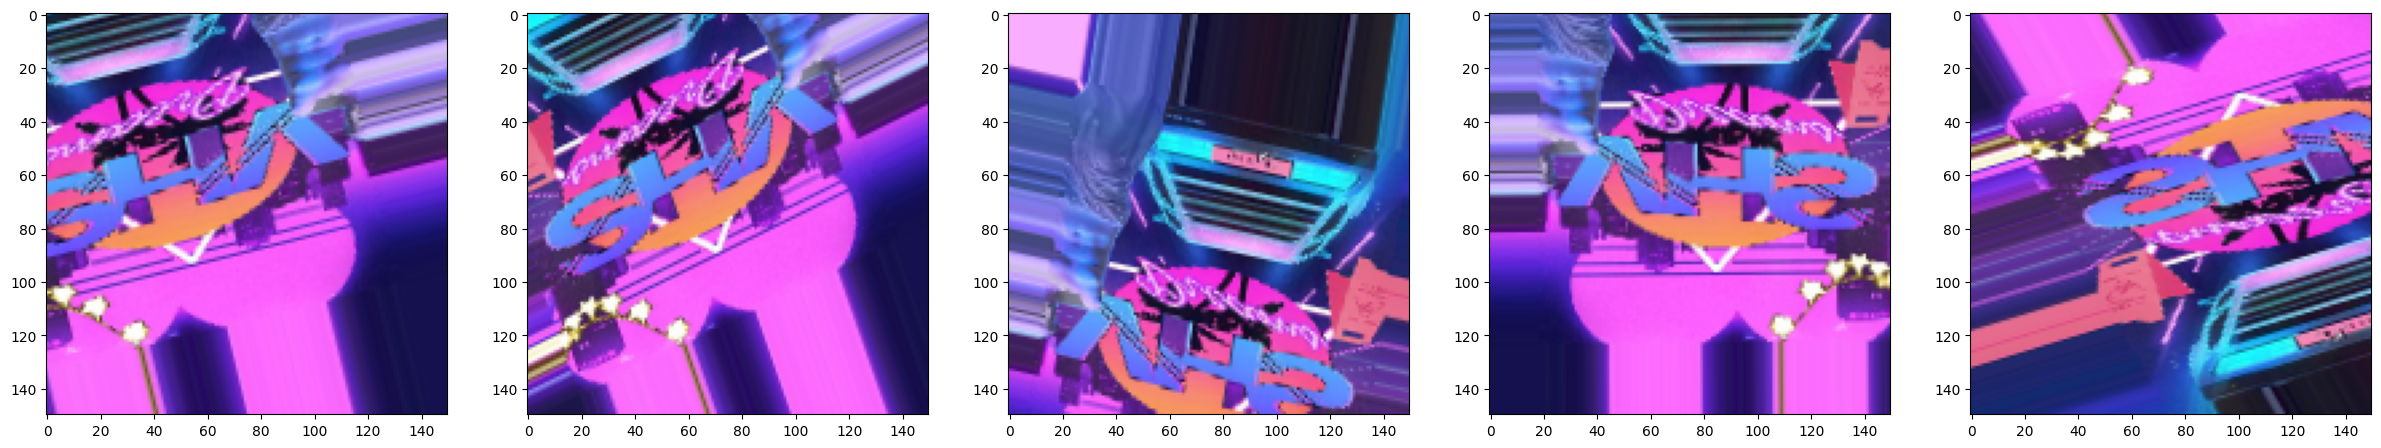

In [4]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 1,
							class_mode ='binary'
							)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

En este caso estamos tomando 8 imágenes y estomos modificando todas 1 vez cada una y las mostramos a manera de ejemplo.

Found 506 images belonging to 2 classes.
(8, 150, 150, 3)
[0. 1. 1. 1. 0. 1. 1. 1.]


<Figure size 640x480 with 0 Axes>

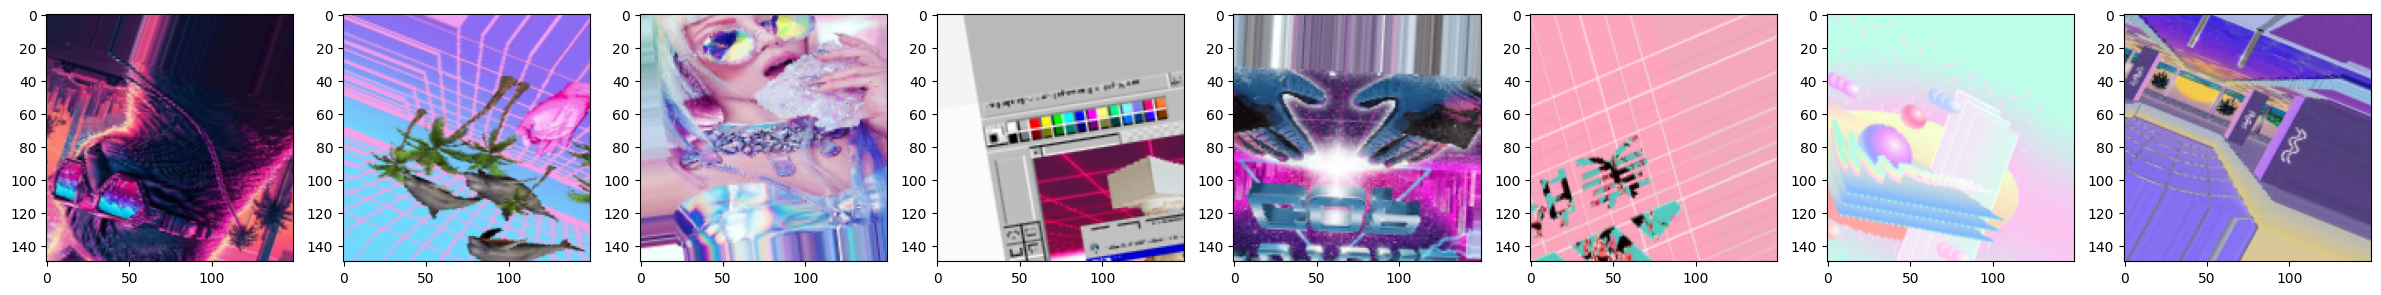

In [5]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary'
							)


images , labels = train_generator[0]

print(images.shape)
print(labels)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]) :  
  axarr[i].imshow(images[i])

También podemos configurar la generación de imágenes para que cada una se salve en el disco duro, de esta forma podemos ver posteriormente con qué imágenes entrenó el modelo. 

In [6]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= path + '/augmented',   
              save_prefix='aug',
              save_format='png'
							)

Found 506 images belonging to 2 classes.


# Red Neuronal 

La arquitectura usada fue la VGG16, una red neuronal que tiene 16 capas de profundidad conectadas sequencialmente entre ellas 

Fue presentada en el paper "Very Deep Convolutional Networks for Large Scale Image Recognition" por Simonyan y Zisserman en 2014, donde tomaron métricas como la exactitud (accuracy) y la pérdida de información (loss) para ver su predicción, el cuál fue de aproximadamente 71.3%	(top-1 accuracy) y 90.1% (top-5 accuracy).

Gracias a que es una arquitectura simple de modificar y entender, fue la que se usó en este proyecto.

## VGG16
Primero se aplicó esta arquitectura sin hacerle ningún cambio

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers, models, layers

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False 
  
model_simpleVGG16 = models.Sequential()
model_simpleVGG16.add(base_model)
model_simpleVGG16.add(layers.Flatten())
model_simpleVGG16.add(layers.Dense(256,activation='relu'))
model_simpleVGG16.add(layers.Dense(1,activation='sigmoid'))

model_simpleVGG16.summary()

model_simpleVGG16.compile(loss='binary_crossentropy',
						              optimizer = optimizers.RMSprop(learning_rate=2e-5),
						              metrics=['acc'])



history_simpleVGG16 = model_simpleVGG16.fit(
                                            train_generator, 
                                            epochs = 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
64/64 [==============================] - 167s 3s/step - loss: 0.6439 - acc: 0.6660
Epoch 2/10
64/64 [==============================] - 157s 2s/step - loss: 0

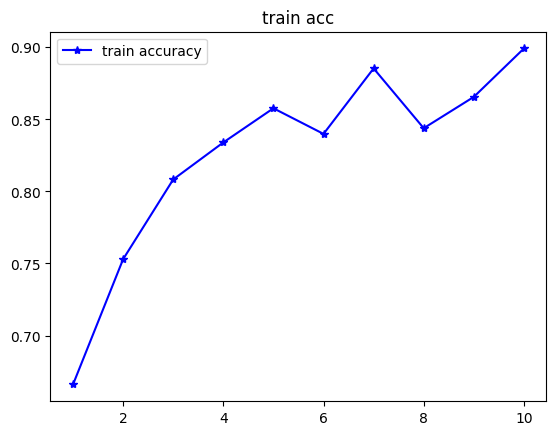

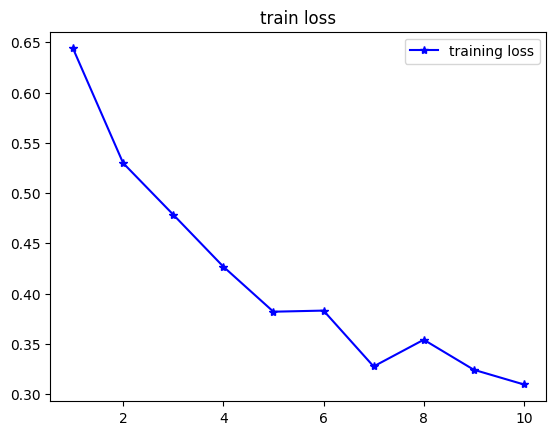

In [8]:
acc_simpleVGG16 = history_simpleVGG16.history['acc']
loss_simpleVGG16 = history_simpleVGG16.history['loss']

epochs_simpleVGG16 = range(1, len(acc_simpleVGG16)+1)

plt.plot(epochs_simpleVGG16, acc_simpleVGG16, 'b*-', label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs_simpleVGG16, loss_simpleVGG16, 'b*-', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [9]:
test_datagen_simpleVGG16 = ImageDataGenerator(1./255)
test_generator_simpleVGG16 = test_datagen_simpleVGG16.flow_from_directory(
																															test_dir,
																															target_size = (150, 150),
																															batch_size = 20,
																															class_mode= 'binary')

test_loss_simpleVGG16, test_acc_simpleVGG16 = model_simpleVGG16.evaluate(test_generator_simpleVGG16, steps = 25)
print('\ntest acc :\n', test_acc_simpleVGG16)


Found 60 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


 3/25 [==>...........................] - ETA: 2:50 - loss: 12.2245 - acc: 0.7833

25/25 [==============================] - 22s 673ms/step - loss: 12.2245 - acc: 0.7833

test acc :
 0.7833333611488342


In [10]:
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

test_imgs_simpleVGG16 = test_generator_simpleVGG16[0][0]
test_labels_simpleVGG16 = test_generator_simpleVGG16[0][1]

print(test_labels_simpleVGG16)

predictions_simpleVGG16 = model_simpleVGG16.predict(test_imgs_simpleVGG16)
classes_x_simpleVGG16 = predictions_simpleVGG16.T
classes_x_simpleVGG16 = np.rint(classes_x_simpleVGG16)

print(classes_x_simpleVGG16)


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


[0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.]
1/1 [==============================] - 5s 5s/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]]


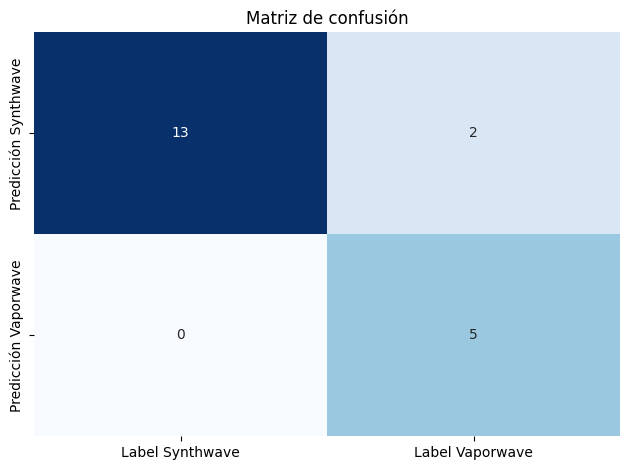

In [11]:
mat_simpleVGG16 = confusion_matrix(classes_x_simpleVGG16[0], test_labels_simpleVGG16)

df_simpleVGG16 = pd.DataFrame(mat_simpleVGG16, index=['Predicción Synthwave', 'Predicción Vaporwave'], columns=['Label Synthwave', 'Label Vaporwave'])

sns.heatmap(df_simpleVGG16, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión"), plt.tight_layout()
plt.show()

El modelo tiene una muy buena predicción ya que solo tiene 2 falsos positivos en una de las etiquetas mientras que los demás datos si las predijo correctamente. De igual manera para tratar de corregir esos falsos positivos, se realizó otras versión del modelo.

## VGG16 con más capas

En esta versión del modelo se le agregó más capas para ver si se puede mejorar

In [12]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False 
  
model_capasVGG16 = models.Sequential()
model_capasVGG16.add(base_model)
model_capasVGG16.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (150,150,3)))
model_capasVGG16.add(layers.Flatten())
model_capasVGG16.add(layers.Dense(256,activation='relu'))
model_capasVGG16.add(layers.Dropout(0.5))
model_capasVGG16.add(layers.Dense(256,activation='relu'))
model_capasVGG16.add(layers.Dropout(0.5))
model_capasVGG16.add(layers.Dense(1,activation='sigmoid'))

model_capasVGG16.summary()

model_capasVGG16.compile(loss='binary_crossentropy',
						             optimizer = optimizers.RMSprop(learning_rate=2e-5),
						             metrics=['acc'])



history_capasVGG16 = model_capasVGG16.fit(
                                          train_generator, 
                                          epochs = 10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 10)          46090     
                                                                 
 flatten_1 (Flatten)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               10496     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)              

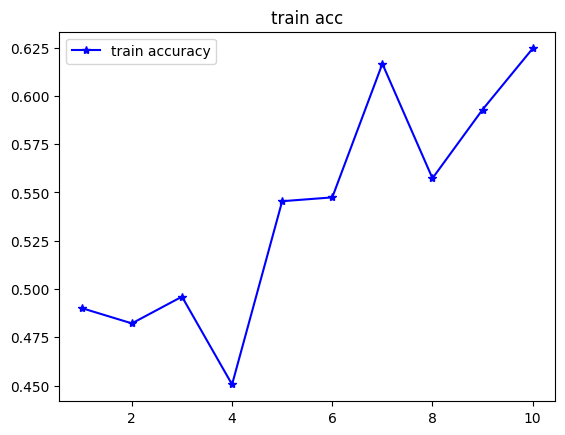

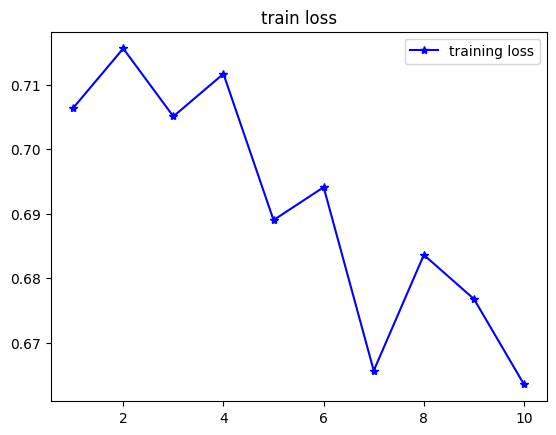

In [13]:
acc_capasVGG16 = history_capasVGG16.history['acc']
loss_capasVGG16 = history_capasVGG16.history['loss']

epochs_capasVGG16 = range(1, len(acc_capasVGG16)+1)

plt.plot(epochs_capasVGG16, acc_capasVGG16, 'b*-', label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs_capasVGG16, loss_capasVGG16, 'b*-', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [14]:
test_datagen_capasVGG16 = ImageDataGenerator(1./255)
test_generator_capasVGG16 = test_datagen_capasVGG16.flow_from_directory(
                                                            test_dir,
                                                            target_size = (150, 150),
                                                            batch_size = 20,
                                                            class_mode= 'binary')

test_loss_capasVGG16, test_acc_capasVGG16 = model_capasVGG16.evaluate(test_generator_capasVGG16, steps = 25)
print('\ntest acc :\n', test_acc_capasVGG16)

Found 60 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


 3/25 [==>...........................] - ETA: 2:38 - loss: 1.4062 - acc: 0.6167

25/25 [==============================] - 20s 605ms/step - loss: 1.4062 - acc: 0.6167

test acc :
 0.6166666746139526


In [15]:
test_imgs_capasVGG16 = test_generator_capasVGG16[0][0]
test_labels_capasVGG16 = test_generator_capasVGG16[0][1]

print(test_labels_simpleVGG16)

predictions_capasVGG16 = model_capasVGG16.predict(test_imgs_capasVGG16)
classes_x_capasVGG16 = predictions_capasVGG16.T
classes_x_capasVGG16 = np.rint(classes_x_capasVGG16)

print(classes_x_capasVGG16)

[0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.]
1/1 [==============================] - 8s 8s/step
[[0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]]


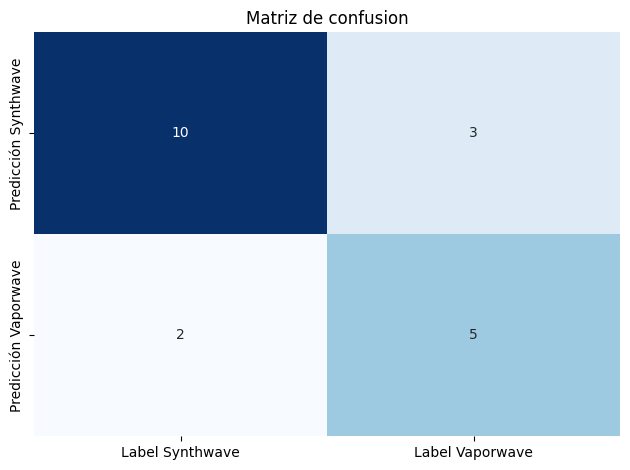

In [23]:
mat_capasVGG16 = confusion_matrix(classes_x_capasVGG16[0], test_labels_capasVGG16)

df_capasVGG16 = pd.DataFrame(mat_capasVGG16, index=['Predicción Synthwave', 'Predicción Vaporwave'], columns=['Label Synthwave', 'Label Vaporwave'])

sns.heatmap(df_capasVGG16, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusion"), plt.tight_layout()
plt.show()

En este modelo se tuvo una peor predicción que el anterior, teniendo ahora 5 falsos positivos. Esto se puede explicar por el overfitting que se produjo al aumentar las capas.

## VGG16 cambiando otros hiperparámetros

En esta versión del modelo se cambiaron otros hiperparámetros para ver si se puede mejorar el primer modelo. En esta ocasión se cambio el optimizador a Adam y se aumentaron el número de epochs de entrenamiento.

In [28]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False 
  
model_hiperVGG16 = models.Sequential()
model_hiperVGG16.add(base_model)
model_hiperVGG16.add(layers.Flatten())
model_hiperVGG16.add(layers.Dense(256,activation='relu'))
model_hiperVGG16.add(layers.Dense(1,activation='sigmoid'))

model_hiperVGG16.summary()

model_hiperVGG16.compile(loss='binary_crossentropy',
                    optimizer = 'Adam',
                    metrics=['acc'])



history_hiperVGG16 = model_hiperVGG16.fit(
                                          train_generator, 
                                          epochs = 30)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               2097408   
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
64/64 [==============================] - 156s 2s/step - loss: 0.6074 - acc: 0.7451
Epoch 2/30
64/64 [==============================] - 155s 2s/step - loss:

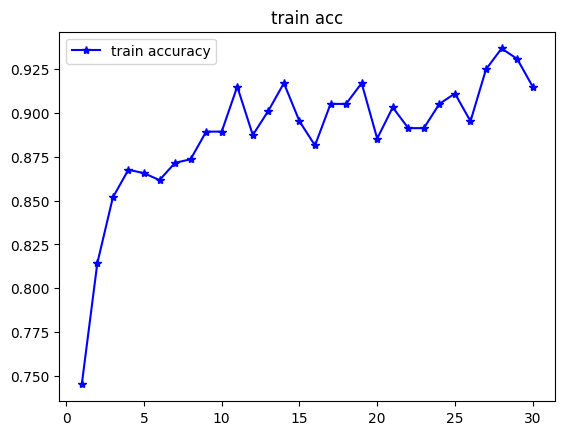

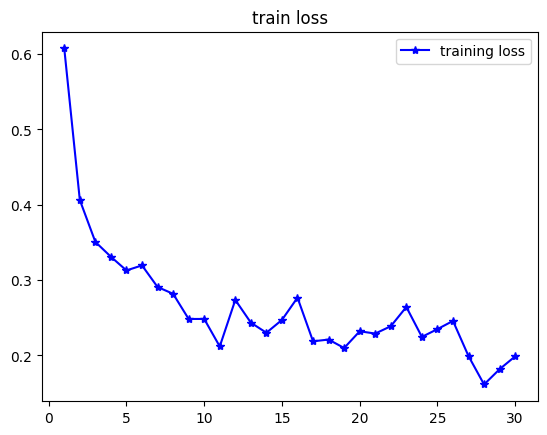

In [35]:
acc_hiperVGG16 = history_hiperVGG16.history['acc']
loss_hiperVGG16 = history_hiperVGG16.history['loss']

epochs_hiperVGG16 = range(1, len(acc_hiperVGG16)+1)

plt.plot(epochs_hiperVGG16, acc_hiperVGG16, 'b*-', label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs_hiperVGG16, loss_hiperVGG16, 'b*-', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [36]:
test_datagen_hiperVGG16 = ImageDataGenerator(1./255)
test_generator_hiperVGG16 = test_datagen_hiperVGG16.flow_from_directory(
                                                            test_dir,
                                                            target_size = (150, 150),
                                                            batch_size = 20,
                                                            class_mode= 'binary')

test_loss_hiperVGG16, test_acc_hiperVGG16 = model_hiperVGG16.evaluate(test_generator_hiperVGG16, steps = 25)
print('\ntest acc :\n', test_acc_hiperVGG16)

Found 60 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


 3/25 [==>...........................] - ETA: 2:09 - loss: 32.6933 - acc: 0.7667

25/25 [==============================] - 17s 491ms/step - loss: 32.6933 - acc: 0.7667

test acc :
 0.7666666507720947


In [37]:
test_imgs_hiperVGG16 = test_generator_hiperVGG16[0][0]
test_labels_hiperVGG16 = test_generator_hiperVGG16[0][1]

print(test_labels_hiperVGG16)

predictions_hiperVGG16 = model_hiperVGG16.predict(test_imgs_hiperVGG16)
classes_x_hiperVGG16 = predictions_hiperVGG16.T
classes_x_hiperVGG16 = np.rint(classes_x_hiperVGG16)

print(classes_x_hiperVGG16)

[1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
1/1 [==============================] - 5s 5s/step
[[1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]]


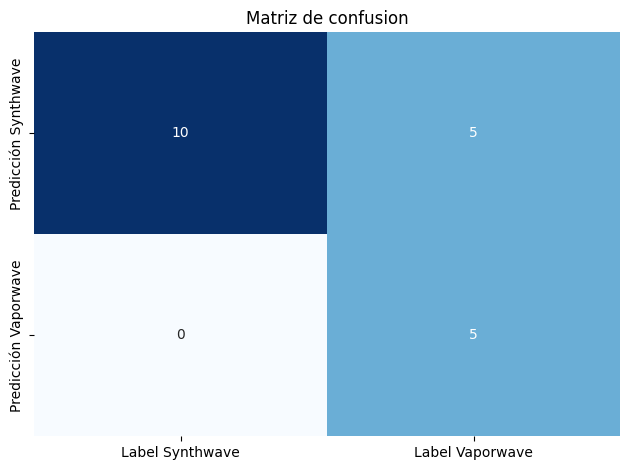

In [38]:
mat_hiperVGG16 = confusion_matrix(classes_x_hiperVGG16[0], test_labels_hiperVGG16)

df_hiperVGG16 = pd.DataFrame(mat_hiperVGG16, index=['Predicción Synthwave', 'Predicción Vaporwave'], columns=['Label Synthwave', 'Label Vaporwave'])

sns.heatmap(df_hiperVGG16, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusion"), plt.tight_layout()
plt.show()

A pesar de tener un Accuracy casi igual al primer modelo, dio más falsos positivos (5), esto es porque la pérdida (Loss) fue mayor, cosa que pudo haber pasado en el entranimiento por los epochs más altos.

# Comparación

In [39]:


df_comp = pd.DataFrame(columns=['Model', 'test loss', 'test accuracy'])
df_comp['Model'] = ['VGG16 original', 'VGG16 con más capas', 'VGG16 cambiando otros hiperparámetros']
df_comp['test loss'] = [test_loss_simpleVGG16, test_loss_capasVGG16, test_loss_hiperVGG16]
df_comp['test accuracy'] = [test_acc_simpleVGG16, test_acc_capasVGG16, test_acc_hiperVGG16]

df_comp

,Model,test loss,test accuracy
0,VGG16 original,12.224532,0.783333
1,VGG16 con más capas,1.406169,0.616667
2,VGG16 cambiando otros hiperparámetros,32.693253,0.766667


## Conclusión

El modelo VGG16 original (el primero que se implementó) fue el que obtuvo una mejor predicción. El modelo con más capas tuvo una menor pérdida, pero también la peor predicción de los tres, esto es por el overfitting. Y el modelo con el optimizador Adam y el aumento de épocas (Epochs) tuvo casi la misma exactitud que el primero, pero una mayor pérdida, por que que su predicción fue un poco más bajo. 